In [28]:
# Importing the required libraries 
import numpy as np
import pandas as pd
import json

**Loading the datasets and formating**

In [29]:
#Importing the transaction dataset
transactions_data = pd.read_csv('transactions_data.csv')


In [32]:
#Read the json file contains labels 
with open('train_fraud_labels.json', 'r') as file:
    f = json.load(file)

In [33]:
#Converting from json format to dataframe
fraud_id = list(f['target'].keys())
fraud_status = list(f['target'].values())

labels = pd.DataFrame({"id": fraud_id, 'Status': fraud_status})
labels.head(3)

,id,Status
0,10649266,No
1,23410063,No
2,9316588,No


In [34]:
#shape of the transaction dataset
print("Shape:", transactions_data.shape)
print(transactions_data.head())

Shape: (13305915, 12)
        id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475331  2010-01-01 00:05:00        430     2860  $200.00   
4  7475332  2010-01-01 00:06:00        848     3915   $46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  errors  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


**Feature engineering**

In [35]:
#converting the id column
labels['id'] = pd.to_numeric(labels['id'])


transactions_data['id'].dtype

# Merging the two dataframes
merged_df = pd.merge(transactions_data, labels, left_on='id', right_on='id', how='inner')


merged_df.head(3)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,Status
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,No
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,No


In [36]:
#Checking for missing values
print("Missing values found before imputation:", merged_df.isnull().sum())


Missing values found before imputation: id                      0
date                    0
client_id               0
card_id                 0
amount                  0
use_chip                0
merchant_id             0
merchant_city           0
merchant_state    1047865
zip               1107377
mcc                     0
errors            8773196
Status                  0
dtype: int64


In [38]:
# Importing the required libraries 

import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from statsmodels.tsa.arima.model import ARIMA


In [42]:
# Handle missing values 

# Impute the missing values of merchant_state column with mode
merged_df['merchant_state'] = merged_df['merchant_state'].fillna(merged_df['merchant_state'].mode()[0])

# Impute the missing values of merchant_state column with mode
merged_df['zip'] = merged_df['zip'].fillna(merged_df['zip'].mode()[0])

# Impute the missing values of merchant_state column with mode
merged_df['errors'] = merged_df['errors'].fillna(merged_df['errors'].mode()[0])

# missing values after imputations
print("Missing values found after imputation:\n", merged_df.isnull().sum())


Missing values found after imputation:
 id                0
date              0
client_id         0
card_id           0
amount            0
use_chip          0
merchant_id       0
merchant_city     0
merchant_state    0
zip               0
mcc               0
errors            0
Status            0
dtype: int64


In [43]:
# Convert 'amount' column to numeric
merged_df['amount'] = merged_df['amount'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Convert the raw date to datetime objects
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Extract useful time-based features
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month
merged_df['day'] = merged_df['date'].dt.day
merged_df['hour'] = merged_df['date'].dt.hour
merged_df['weekday'] = merged_df['date'].dt.weekday


merged_df.head(3)


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,Status,year,month,day,hour,weekday
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,Insufficient Balance,No,2010,1,1,0,4
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,Insufficient Balance,No,2010,1,1,0,4
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,Insufficient Balance,No,2010,1,1,0,4


**Modelling**

In [44]:
from sklearn.preprocessing import LabelEncoder
#from sklearn.ensemble import IsolationForest

# categorical columns in the dataset
categorical = ['use_chip', 'merchant_city', 'merchant_state', 'errors']

# Using LabelEncoder for converting categorical into numeric values
label_encoder = LabelEncoder()

# each categorical column
for c in categorical:
    merged_df[c] = label_encoder.fit_transform(merged_df[c].astype(str))

#   setting X for modelling
X = merged_df.drop(['Status', 'date'], axis=1)  

# Preparing target variable
y = merged_df['Status'].apply(lambda x: 1 if x == 'Yes' else 0)

"""""
# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.5)  # 'contamination' is the proportion of anomalies (fraud)

# Fit the model on the feature set X
model.fit(X)

# Predict fraud (1 = fraud, 0 = not fraud)
y_pred = model.predict(X)

# Convert predictions to 1 and 0 (fraud or not fraud)
y_pred = [1 if i == -1 else 0 for i in y_pred]

# Check the result
print("Fraud predictions:", y_pred[:10])


"""""

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split the data 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using Random Forest model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Training the model
model.fit(X_train, y_train)

# Predicting on test data
y_pred = model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report for the model:\n{classification_report(y_test, y_pred)}")


Random Forest Accuracy: 0.9996477832498502
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780357
           1       0.98      0.77      0.87      2636

    accuracy                           1.00   1782993
   macro avg       0.99      0.89      0.93   1782993
weighted avg       1.00      1.00      1.00   1782993



**Evaluation**

In [45]:
# Evaluation metrics for classification
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

Accuracy: 0.9996477832498502
Precision: 0.9836223506743738
Recall: 0.7746585735963581
F1-Score: 0.8667232597623089


**Visualization**

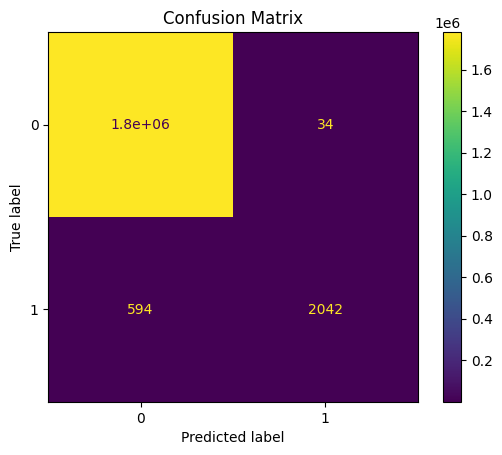

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
CM = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix')  
plt.show()

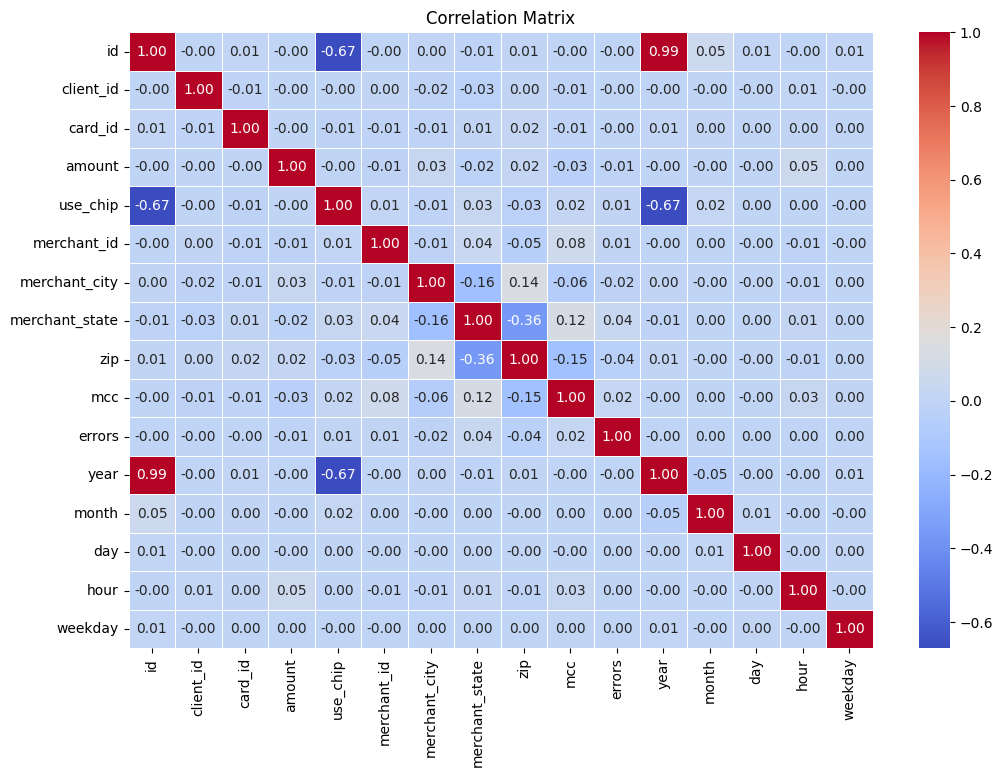

In [47]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Calculate correlation matrix for the numeric columns
correlation_matrix = X.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Finding the relationship between attributes via correlation matrix

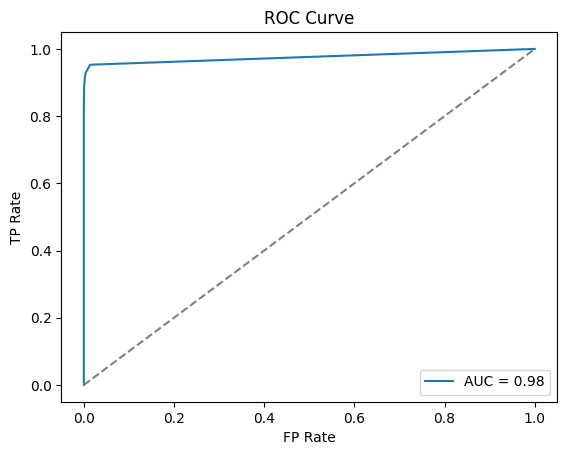

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute probabilities for curve
y_pred_p = model.predict_proba(X_test)[:, 1]

#  ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_p)

# AUC score
auc_score = roc_auc_score(y_test, y_pred_p)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [50]:
# Convert raw date column to datetime objects
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['date_only'] = merged_df['date'].dt.date

# fraud cases by day
fraud_cases = merged_df.groupby('date_only')['Status'].apply(lambda x: (x == 'Yes').sum())


fraud_cases.index = pd.to_datetime(fraud_cases.index)


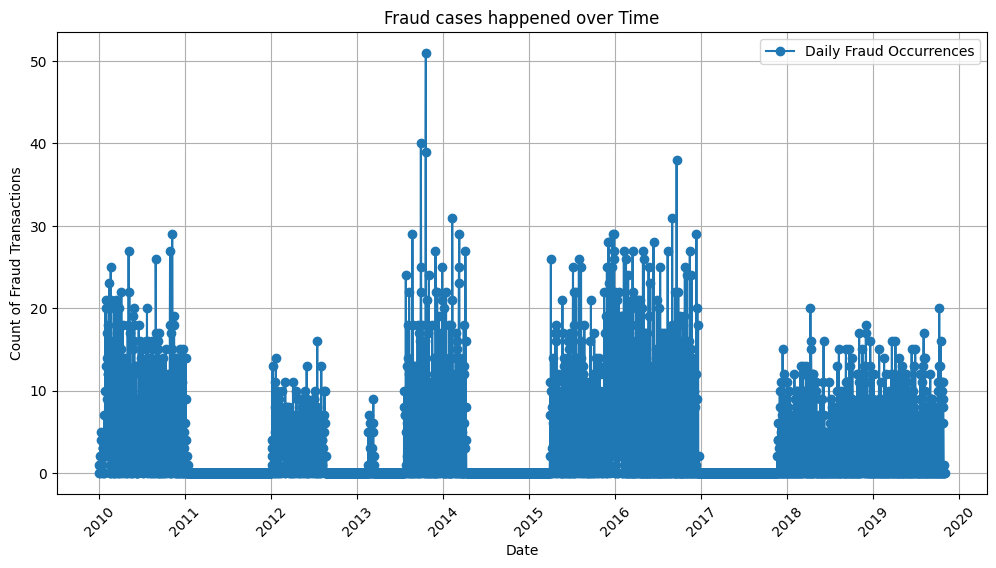

In [51]:

fraud_cases.index = pd.to_datetime(fraud_cases.index)

# Sorting by date 
fraud_cases = fraud_cases.sort_index()

# Plot the fraud cases happened over Time
plt.figure(figsize=(12, 6))
plt.plot(fraud_cases, marker='o', label='Daily Fraud Occurrences')
plt.title("Fraud cases happened over Time")
plt.xlabel("Date")
plt.ylabel("Count of Fraud Transactions")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [19]:
"""
#FUTURE WORK

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Load your dataset (merged_df)
# Replace with your actual dataset loading step if necessary
#merged_df = pd.read_csv("your_dataset.csv")

# Convert transaction_date to datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Aggregate fraud counts by day
daily_fraud = merged_df.groupby('date')['Status'].sum().reset_index()
daily_fraud.rename(columns={'Status': 'fraud_count'}, inplace=True)

# Set transaction_date as index (optional)
daily_fraud.set_index('date', inplace=True)

# Ensure fraud_count column is clean
print("Checking data for issues...")
print(daily_fraud['fraud_count'].head())
print(daily_fraud['fraud_count'].isnull().sum())  # Check for missing values

# Fill missing values and ensure numerical data
daily_fraud['fraud_count'].fillna(0, inplace=True)
daily_fraud['fraud_count'] = pd.to_numeric(daily_fraud['fraud_count'], errors='coerce')

# Check if daily_fraud is empty
if daily_fraud.empty:
    raise ValueError("The daily_fraud DataFrame is empty after preprocessing. Check your input data.")

# Scale the fraud counts to a range of [0, 1] for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_fraud['fraud_count'].values.reshape(-1, 1))

print("Scaling completed successfully.")

# Function to create sequences for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Use the last `time_step` days as input
        y.append(data[i + time_step, 0])      # Predict the next day's fraud count
    return np.array(X), np.array(y)

# Create sequences with a look-back period of 7 days
time_step = 7
X, y = create_dataset(scaled_data, time_step)

# Reshape X for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])


# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)


# Classification threshold for fraud detection
threshold = 0.5
y_test_binary = (y_test_rescaled >= threshold).astype(int).flatten()
y_pred_binary = (y_pred_rescaled >= threshold).astype(int).flatten()

# Calculate classification metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
"""

Checking data for issues...
date
2010-01-01 00:01:00      No
2010-01-01 00:02:00    NoNo
2010-01-01 00:06:00      No
2010-01-01 00:07:00      No
2010-01-01 00:14:00      No
Name: fraud_count, dtype: object
0


/tmp/ipykernel_30/402158818.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_fraud['fraud_count'].fillna(0, inplace=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Scaling completed successfully.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1261s 27ms/step - loss: nan - val_loss: nan
Epoch 2/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1249s 27ms/step - loss: nan - val_loss: nan
Epoch 3/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1245s 27ms/step - loss: nan - val_loss: nan
Epoch 4/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1247s 27ms/step - loss: nan - val_loss: nan
Epoch 5/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1244s 27ms/step - loss: nan - val_loss: nan
Epoch 6/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1252s 27ms/step - loss: nan - val_loss: nan
Epoch 7/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1234s 27ms/step - loss: nan - val_loss: nan
Epoch 8/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1263s 27ms/step - loss: nan - val_loss: nan
Epoch 9/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1257s 27ms/step - loss: nan - val_loss: nan
Epoch 10/10
46013/46013 ━━━━━━━━━━━━━━━━━━━━ 1248s 27ms/step - loss: nan - val_loss: nan
23007/23007 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Metrics:
Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
